In [140]:
import os
import zipfile
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [141]:

# Define the source directory where your zip files are located.
source_directory = "./data/"

# Define the destination directory for the combined CSV files.
destination_directory = "./extracted/"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)



pdf_pages = PdfPages(destination_directory+'output_plots.pdf')

In [142]:

# Initialize data frames to store the combined CSV data
combined_click_data = pd.DataFrame()
combined_overall_data = pd.DataFrame()
combined_task_data = pd.DataFrame()

# Loop through all files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith(".zip"):
        zip_filepath = os.path.join(source_directory, filename)

        # Extract the relevant information from the file name
        parts = filename.split("_")
        condition_code = parts[1]
        attempt = parts[2]
        condition = parts[3]

        # Extract the zip file
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(source_directory)

        # Read and merge the CSV files
        click_csv_file = f"WebFitts_{condition_code}_{attempt}_{condition}_{parts[4].split('.')[0]}_click.csv"
        overall_csv_file = f"WebFitts_{condition_code}_{attempt}_{condition}_{parts[4].split('.')[0]}_overall.csv"
        task_csv_file = f"WebFitts_{condition_code}_{attempt}_{condition}_{parts[4].split('.')[0]}_task.csv"

        click_data = pd.read_csv(os.path.join(source_directory, click_csv_file))
        overall_data = pd.read_csv(os.path.join(source_directory, overall_csv_file))
        task_data = pd.read_csv(os.path.join(source_directory, task_csv_file))

        combined_click_data = pd.concat([combined_click_data, click_data])
        combined_overall_data = pd.concat([combined_overall_data, overall_data])
        combined_task_data = pd.concat([combined_task_data, task_data])

        # Clean up by removing the extracted CSV files
        os.remove(os.path.join(source_directory, click_csv_file))
        os.remove(os.path.join(source_directory, overall_csv_file))
        os.remove(os.path.join(source_directory, task_csv_file))


In [143]:

# Save the combined dataframes to CSV files in the destination directory
combined_click_data.to_csv(os.path.join(destination_directory, "Data_Mouse_click.csv"), index=False)
combined_overall_data.to_csv(os.path.join(destination_directory, "Data_Mouse_overall.csv"), index=False)
combined_task_data.to_csv(os.path.join(destination_directory, "Data_Mouse_task.csv"), index=False)


In [144]:

# Load the combined data
data_click = pd.read_csv(destination_directory+"Data_Mouse_click.csv")
data_overall = pd.read_csv(destination_directory+"Data_Mouse_overall.csv")


# Calculate Completion Time (ms) and Error Rate
data_click['Error Rate'] = (data_click['Incorrect'] / data_click['Number of Targets']) * 100  # Convert to percentage

# Separate data for C1 and C2 conditions
data_c1 = data_click[data_click['Condition Code'] == 'C1']
data_c2 = data_click[data_click['Condition Code'] == 'C2']

# Perform a t-test for Completion Time (ms) between C1 and C2
t_stat_time, p_value_time = stats.ttest_ind(data_c1['Completion Time (ms)'], data_c2['Completion Time (ms)'], equal_var=False)

# Perform a t-test for Error Rate between C1 and C2
t_stat_error, p_value_error = stats.ttest_ind(data_c1['Error Rate'], data_c2['Error Rate'], equal_var=False)

# Define a significance level (alpha)
alpha = 0.05

# Check if the p-value for Completion Time (ms) is less than alpha
if p_value_time < alpha:
    print(f"The t-test result for Completion Time (ms) is statistically significant (p-value = {p_value_time}).")
    print("There is a significant difference in Completion Time (ms) between C1 and C2.")
else:
    print(f"The t-test result for Completion Time (ms) is not statistically significant (p-value = {p_value_time}).")
    print("There is no significant difference in Completion Time (ms) between C1 and C2.")

# Check if the p-value for Error Rate is less than alpha
if p_value_error < alpha:
    print(f"The t-test result for Error Rate is statistically significant (p-value = {p_value_error}).")
    print("There is a significant difference in Error Rate between C1 and C2.")
else:
    print(f"The t-test result for Error Rate is not statistically significant (p-value = {p_value_error}).")
    print("There is no significant difference in Error Rate between C1 and C2.")

The t-test result for Completion Time (ms) is statistically significant (p-value = 2.790176012614061e-32).
There is a significant difference in Completion Time (ms) between C1 and C2.
The t-test result for Error Rate is statistically significant (p-value = 0.007886668046366422).
There is a significant difference in Error Rate between C1 and C2.


In [145]:
# Extract unique participant codes
participant_codes = data_click['Participant Code'].unique()

# Create a dictionary to store "Completion Time" data for each participant
completion_time_data = {}

# Extract unique conditions
conditions = ['C1','C2']

# Populate the dictionary with data grouped by condition
for condition in conditions:
    completion_time_data[condition] = data_click[data_click['Condition Code'] == condition]['Completion Time (ms)']

# Initialize a list to store the arrays of completion time data
completion_time_arrays = []

# Populate the list with arrays of completion time data
for condition_code in conditions:
    data_participant = completion_time_data[condition_code]
    completion_time_arrays.append(data_participant.to_numpy())  # Convert the Pandas Series to a NumPy array


In [146]:

# Initialize an empty list to store ANOVA results
anova_results = []

# Perform one-way ANOVA for each participant
for condition_code in conditions:
    data_participant = completion_time_data[condition_code]
    f_statistic, p_value_anova = stats.f_oneway(*completion_time_arrays)
    anova_results.append((condition_code, f_statistic, p_value_anova))

# Define a significance level (alpha)
alpha = 0.05

# Check the ANOVA result
if p_value_anova < alpha:
    print("The ANOVA result for Completion Time (ms) for conditions 'c1' and 'c2' is statistically significant (p-value = {p_value_anova}).")
    print("There is a significant difference between conditions 'c1' and 'c2'.")
else:
    print("The ANOVA result for Completion Time (ms) for conditions 'c1' and 'c2' is not statistically significant (p-value = {p_value_anova}).")
    print("There is no significant difference between conditions 'c1' and 'c2'.")


The ANOVA result for Completion Time (ms) for conditions 'c1' and 'c2' is statistically significant (p-value = {p_value_anova}).
There is a significant difference between conditions 'c1' and 'c2'.


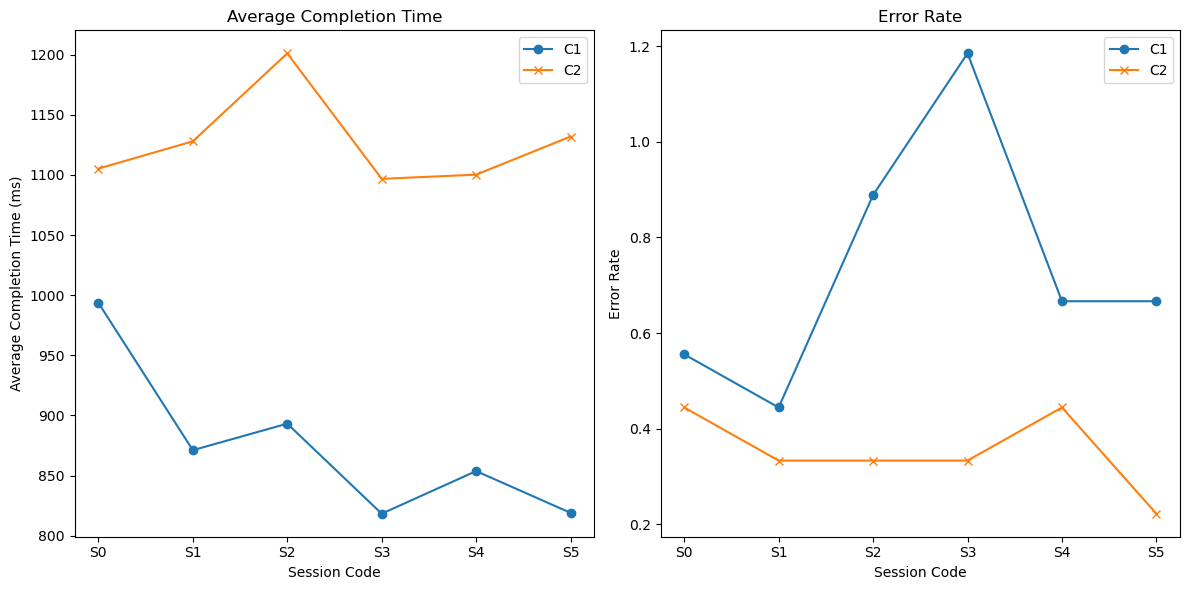

The ANOVA result for Completion Time is statistically significant (p-value = 3.1830556633365074e-32).
There is a significant difference between C1 and C2.


In [147]:
# Define your condition labels (C1 and C2)
condition_c1 = 'C1'
condition_c2 = 'C2'

# Calculate descriptive statistics
average_completion_time_c1 = data_click[data_click['Condition Code'] == condition_c1].groupby('Session Code')['Completion Time (ms)'].mean()
average_completion_time_c2 = data_click[data_click['Condition Code'] == condition_c2].groupby('Session Code')['Completion Time (ms)'].mean()
error_c1 = data_click[data_click['Condition Code'] == condition_c1].groupby('Session Code')['Error Rate'].mean()
error_c2 = data_click[data_click['Condition Code'] == condition_c2].groupby('Session Code')['Error Rate'].mean()

# Create visualizations
plt.figure(figsize=(12, 6))

# Average completion time comparison
plt.subplot(1, 2, 1)
plt.plot(average_completion_time_c1.index, average_completion_time_c1, marker='o', label=condition_c1)
plt.plot(average_completion_time_c2.index, average_completion_time_c2, marker='x', label=condition_c2)
plt.xlabel('Session Code')
plt.ylabel('Average Completion Time (ms)')
plt.title('Average Completion Time')
plt.legend()

# Error rate comparison
plt.subplot(1, 2, 2)
plt.plot(error_c1.index, error_c1, marker='o', label=condition_c1)
plt.plot(error_c2.index, error_c2, marker='x', label=condition_c2)
plt.xlabel('Session Code')
plt.ylabel('Error Rate')
plt.title('Error Rate')
plt.legend()

plt.tight_layout()

# Display the visualizations
pdf_pages.savefig()
plt.show()

# Hypothesis testing (perform ANOVA for completion time)
f_statistic, p_value_anova = stats.f_oneway(
    data_click[data_click['Condition Code'] == condition_c1]['Completion Time (ms)'],
    data_click[data_click['Condition Code'] == condition_c2]['Completion Time (ms)']
)
# Explain hypothesis testing results
alpha = 0.05

if p_value_anova < alpha:
    print(f"The ANOVA result for Completion Time is statistically significant (p-value = {p_value_anova}).")
    print(f"There is a significant difference between {condition_c1} and {condition_c2}.")
else:
    print(f"The ANOVA result for Completion Time is not statistically significant (p-value = {p_value_anova}).")
    print(f"There is no significant difference between {condition_c1} and {condition_c2}.")


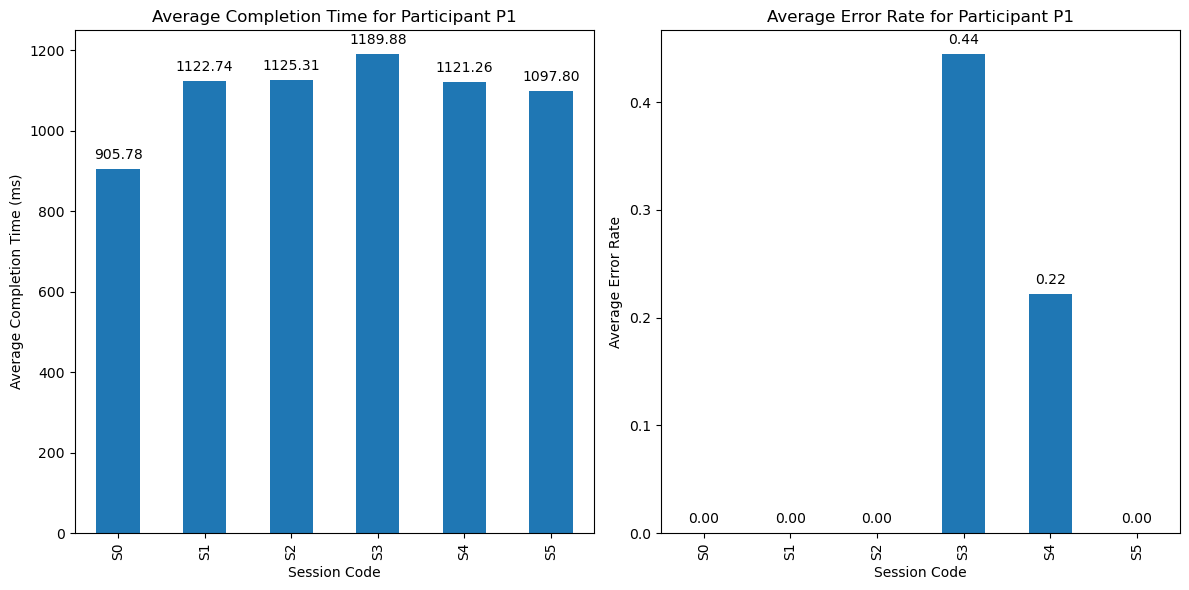

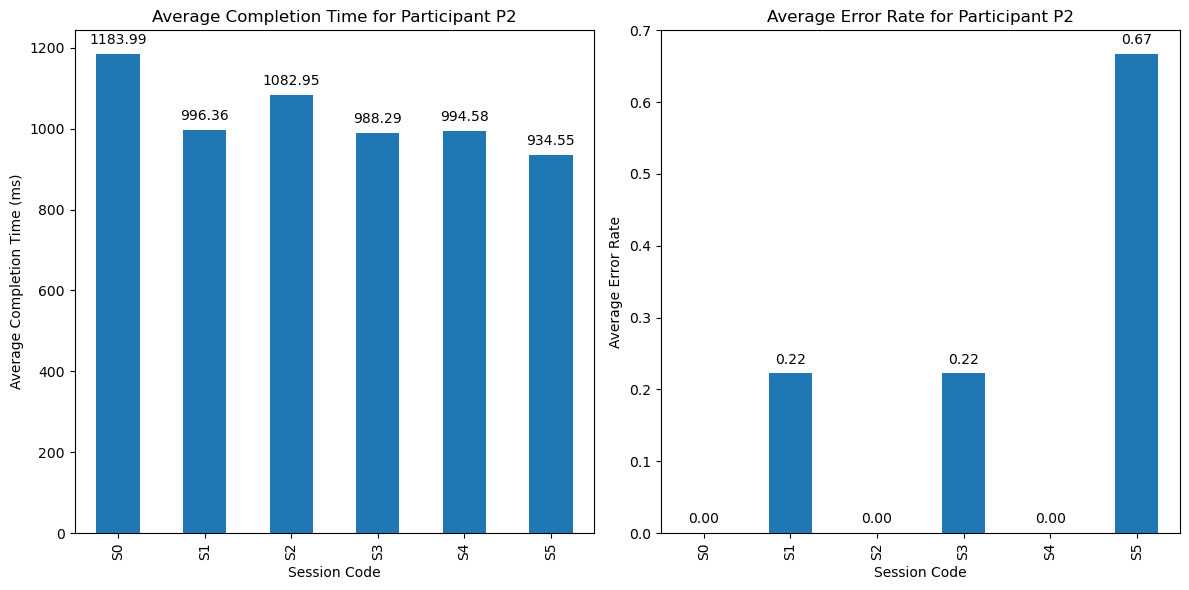

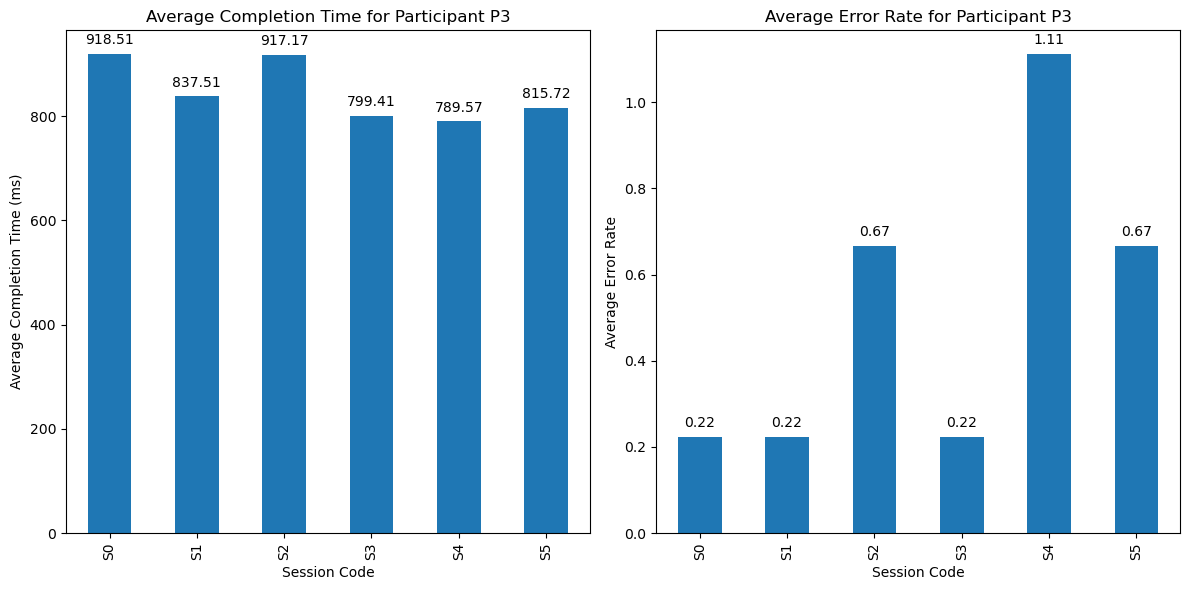

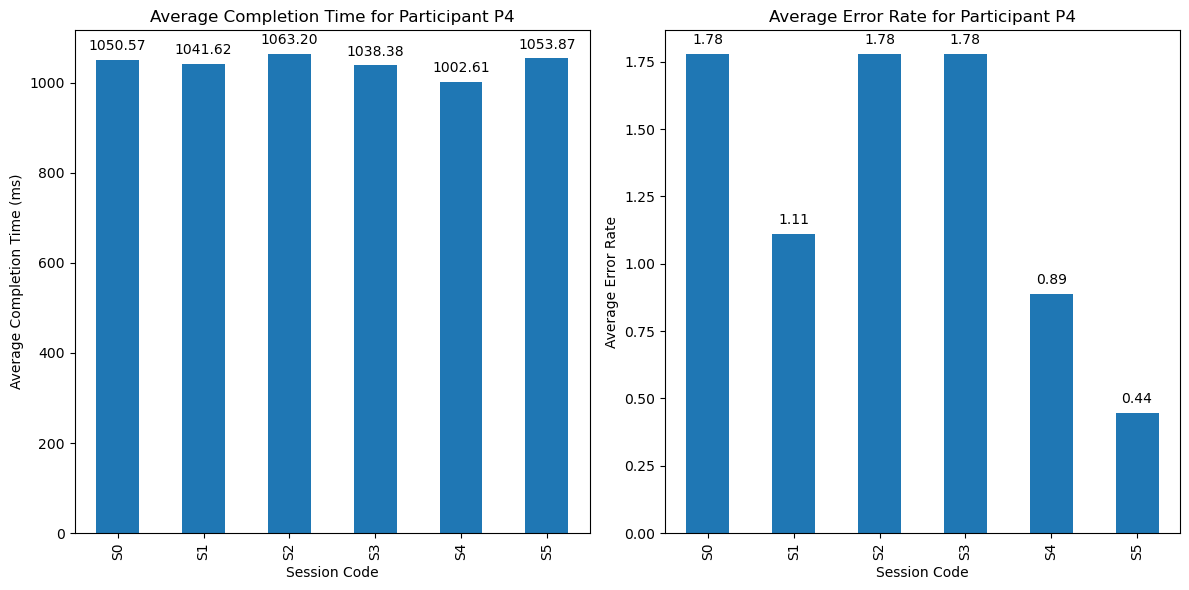

In [148]:
import matplotlib.pyplot as plt

# Group the data by 'Participant Code'
grouped_data = data_click.groupby('Participant Code')

# Function to add values on top of each bar
def add_values(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}".format(y_value)
        ax.annotate(
            label, 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords="offset points", 
            ha='center', 
            va=va
        )

# Plot average completion time and error for each participant
for participant, group in grouped_data:
    plt.figure(figsize=(12, 6))
    
    # Plot average completion time
    plt.subplot(1, 2, 1)
    plt.title(f'Average Completion Time for Participant {participant}')
    ax1 = group.groupby('Session Code')['Completion Time (ms)'].mean().plot(kind='bar')
    plt.xlabel('Session Code')
    plt.ylabel('Average Completion Time (ms)')
    
    add_values(ax1)  # Add values on top of bars
    
    # Plot average error rate
    plt.subplot(1, 2, 2)
    plt.title(f'Average Error Rate for Participant {participant}')
    ax2 = group.groupby('Session Code')['Error Rate'].mean().plot(kind='bar')
    plt.xlabel('Session Code')
    plt.ylabel('Average Error Rate')
    
    add_values(ax2)  # Add values on top of bars
    
    plt.tight_layout()
    pdf_pages.savefig()
    
    plt.show()


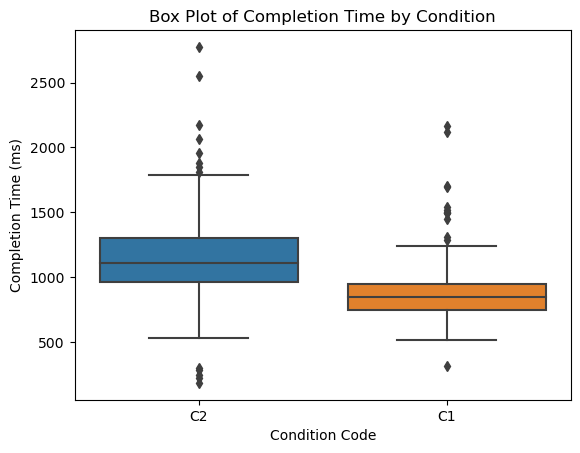

In [149]:


# Create a box plot to compare variance in completion time for C1 and C2
sns.boxplot(x='Condition Code', y='Completion Time (ms)', data=data_click)
plt.title('Box Plot of Completion Time by Condition')
plt.xlabel('Condition Code')
plt.ylabel('Completion Time (ms)')
pdf_pages.savefig()
plt.show()


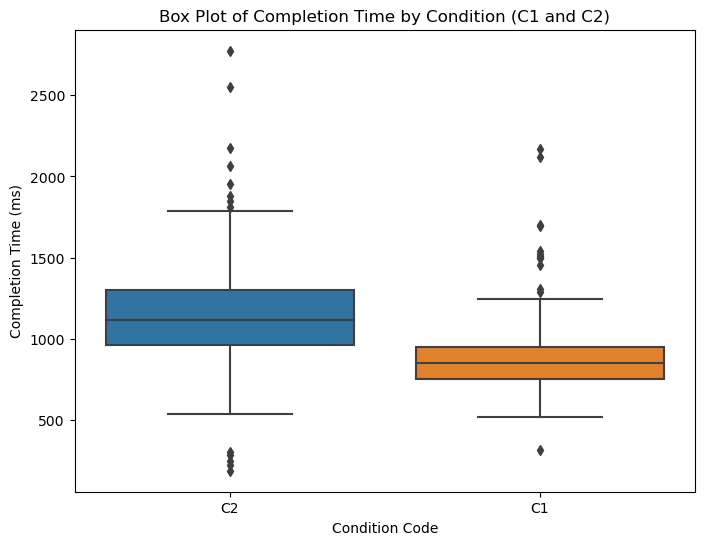

In [150]:


# Create box plots to compare variances in completion time between conditions C1 and C2
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition Code', y='Completion Time (ms)', data=data_click)
plt.title('Box Plot of Completion Time by Condition (C1 and C2)')
plt.xlabel('Condition Code')
plt.ylabel('Completion Time (ms)')
pdf_pages.savefig()
plt.show()


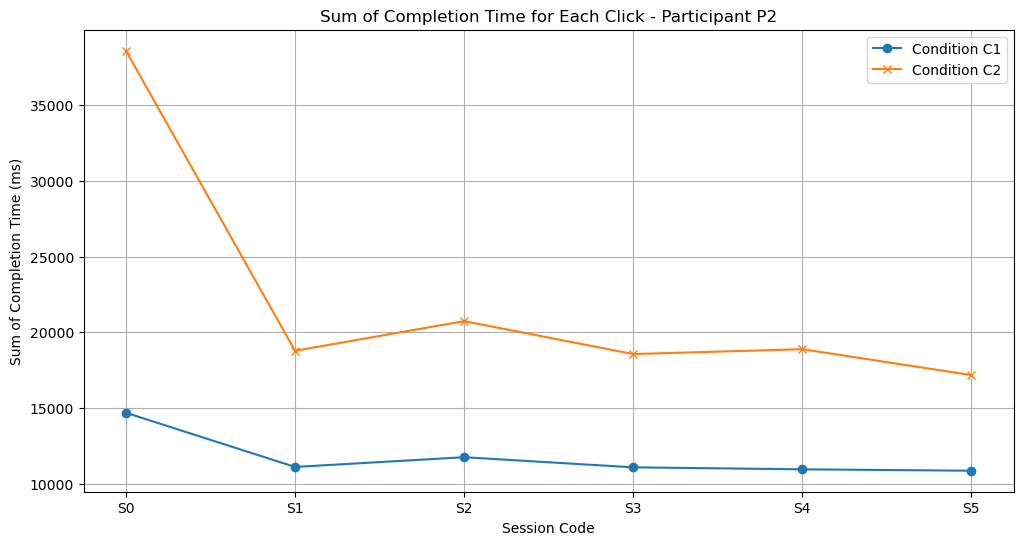

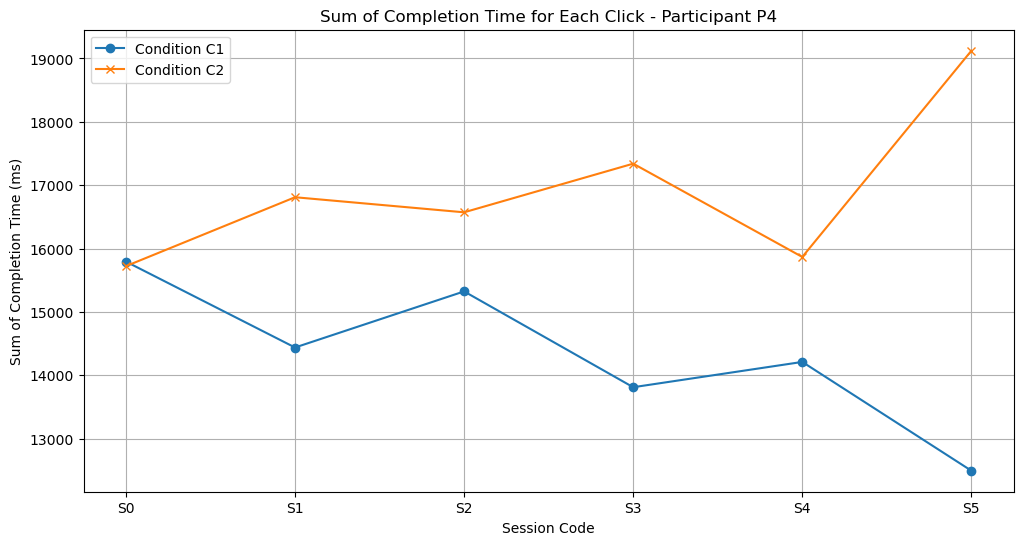

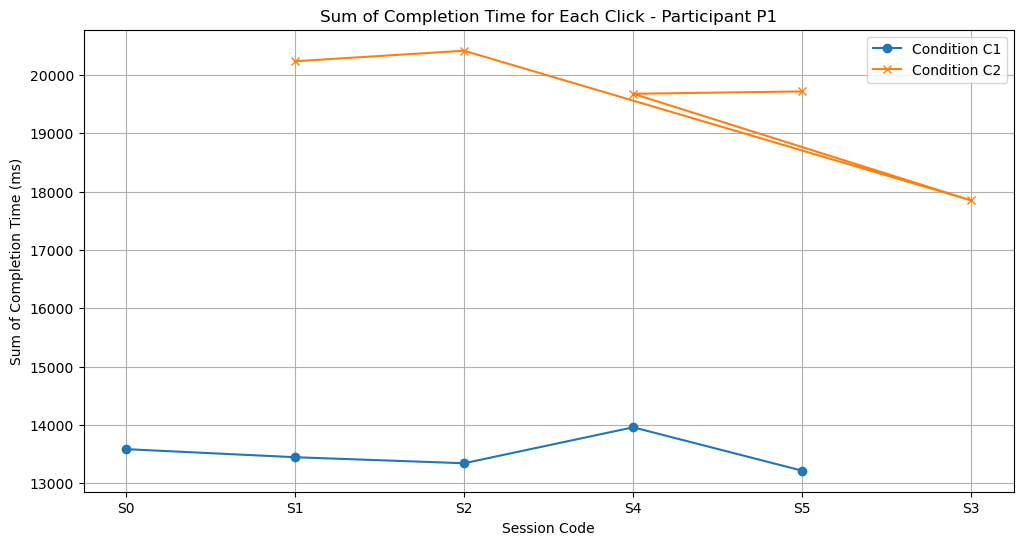

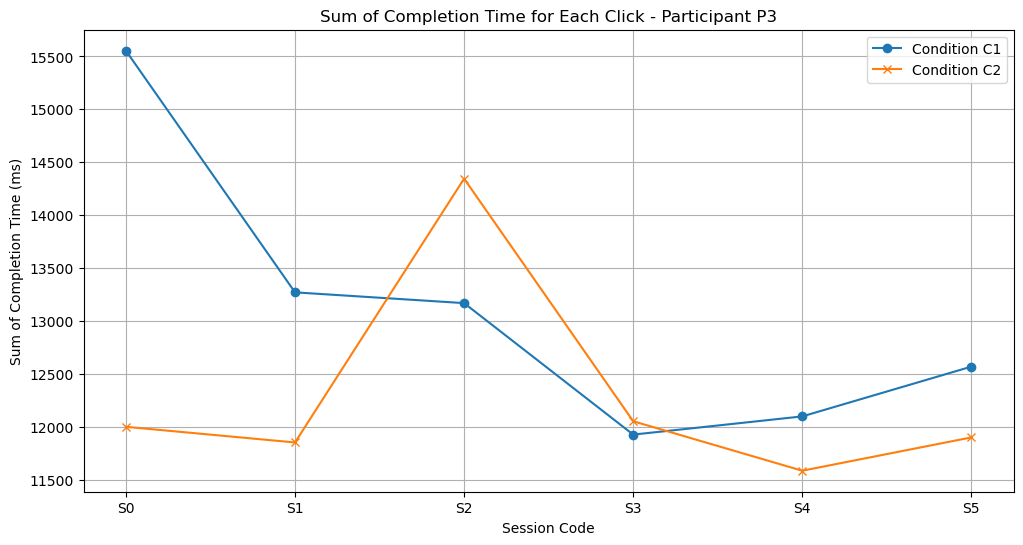

In [151]:


# Extract unique participant codes
participant_codes = data_click['Participant Code'].unique()

# Set up a color palette for conditions
colors = {'C1': 'blue', 'C2': 'red'}

for participant_code in participant_codes:
    
    # Filter data for the specific participant
    participant_data = data_click[data_click['Participant Code'] == participant_code]

    # Separate data by condition (e.g., C1 and C2)
    condition_c1 = participant_data[participant_data['Condition Code'] == 'C1']
    condition_c2 = participant_data[participant_data['Condition Code'] == 'C2']

    # Calculate the sum of completion time for each click for each condition
    sum_completion_time_c1 = condition_c1.groupby('Session Code')['Completion Time (ms)'].sum()
    sum_completion_time_c2 = condition_c2.groupby('Session Code')['Completion Time (ms)'].sum()

    # Create a line plot for the sum of completion time for each click, separated by condition
    plt.figure(figsize=(12, 6))
    plt.plot(sum_completion_time_c1.index, sum_completion_time_c1, label='Condition C1', marker='o')
    plt.plot(sum_completion_time_c2.index, sum_completion_time_c2, label='Condition C2', marker='x')

    plt.title(f'Sum of Completion Time for Each Click - Participant {participant_code}')
    plt.xlabel('Session Code')
    plt.ylabel('Sum of Completion Time (ms)')
    plt.legend()
    plt.grid(True)
    pdf_pages.savefig()

    plt.show()




In [152]:
# Rename columns to make them valid variable names
data_click.rename(columns={"Completion Time (ms)": "CompletionTime", "Condition Code": "Hand", "Session Code": "Session"}, inplace=True)

# Define the ANOVA model
formula = 'CompletionTime ~ Hand * Session'
model = ols(formula, data=data_click).fit()

# Perform two-way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)



# Print the ANOVA table
print(anova_table)

                    sum_sq     df           F        PR(>F)
Hand          1.113604e+07    1.0  159.592554  4.515778e-33
Session       8.648253e+05    5.0    2.478794  3.076647e-02
Hand:Session  8.163660e+05    5.0    2.339898  4.027385e-02
Residual      4.835609e+07  693.0         NaN           NaN


In [153]:
# Perform Tukey's HSD post hoc test
tukey = pairwise_tukeyhsd(endog=data_click['CompletionTime'], groups=data_click['Hand'])

print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
    C1     C2 249.9236   0.0 210.4598 289.3874   True
-----------------------------------------------------


In [154]:
#always last code
pdf_pages.close()